# Introduction

**GradCafe** is a platform where grad school applicants share admission status and communicate updates. One thing all applicants need is information - when to expect an interview, whether being put in a waiting list or receiving an email starting with Congratulations. The uncertainty that comes with these questions can be relieved to certain degree with information from other applicants.

As freshly admitted grad students, we are curious what we can know about application in Statistics over the last decade from **GradCafe**, where we have access to 10,000 application results from 2010 to 2020 with information on the program, year, applicant undergrad GPA, GRE result, admission status, etc.

We also incorporate two major university rankings in Statistics: **U.S. News** and **QS World University Rankings** as these rankings are reliable indicators of academic reputation of a particular university and program, which can affect decisions of both applicants and programs significantly. Besides, these two rankings are selected to represent the major domestic and international evaluation of universities.

With three datasets on admission result and ranking scraped, we are able to answer two major questions below.
1. What kind of programs are popular among the applicants in Statistics?
2. What kind of applicants are usually preferred by Statistics graduate programs?

In [1]:
# import prerequisite packages and self-defined functions
import sys
import graphviz # plot decision tree gracefully
import pandas as pd
import numpy as np
import plotnine as p9
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

sys.path.append("../code") # append path to import local .py file
from plot_functions import * # import plot functions for notes analysis
from plot_geopandas import * # import interactive map plot functions
from clean import decision_tree_process # import predictor preprocessing function

# Exploratory Data Analysis

We first conducted exploratory data analysis on the Gradcafe dataset and got some prelimitary findings about applicants in Statistics.

In [2]:
# df: data frame obtained by data munging, including data crawled from GradCafe, U.S. News. (clean.py)
df.head()

,institution,program,degree,season,admission_status,admission_via,admission_date,ST,Date_added,notes,Undergrad_GPA,GRE_V,GRE_Q,GRE_W,GRE_sub,USnew_stat_score,postal,USnew_overall_score
0,University of California--Santa Barbara (Depar...,Applied Probability & Statistics,PhD,F20,Other,Other,2020-03-04,O,2020-03-04,Has anyone heard from this program? Only saw 3...,NaN,NaN,NaN,NaN,NaN,2.7,CA,75.6
1,University of California--Santa Barbara (Depar...,Statistics,PhD,F20,Accepted,E-mail,2020-02-13,A,2020-02-19,NaN,NaN,NaN,NaN,NaN,NaN,2.7,CA,75.6
2,University of California--Santa Barbara (Depar...,Applied Probability & Statistics,PhD,F20,Other,Other,2020-03-04,O,2020-03-04,Has anyone heard from this program? Only saw 3...,NaN,NaN,NaN,NaN,NaN,2.7,CA,75.6
3,University of California--Santa Barbara (Depar...,Statistics,PhD,F20,Accepted,E-mail,2020-02-13,A,2020-02-19,NaN,NaN,NaN,NaN,NaN,NaN,2.7,CA,75.6
4,University of California--Santa Barbara (Depar...,Statistics,PhD,F20,Accepted,E-mail,2020-02-07,A,2020-02-07,NaN,3.5,164.0,168.0,5.0,NaN,2.7,CA,75.6


## What is the most popular Statistics PhD program?
We show counts of reports on each school.

In [3]:
df.loc[df["degree"]=="PhD"]["institution"].value_counts().head(20)

Carnegie Mellon University (Department of Statistics)                  333
North Carolina State University--Raleigh (Department of Statistics)    310
University of Washington (Department of Statistics)                    291
University of Michigan--Ann Arbor (Department of Statistics)           282
University of Chicago (Department of Statistics)                       272
Duke University (Department of Statistical Science)                    216
University of California--Berkeley (Department of Statistics)          211
University of Wisconsin--Madison (Department of Statistics)            208
Columbia University (Department of Statistics)                         183
Pennsylvania State University (Department of Statistics)               172
University of Illinois--Urbana-Champaign (Department of Statistics)    163
Harvard University (Department of Statistics)                          163
Cornell University (Department of Statistical Science)                 162
Stanford University (Depa

## Compare GPA grouped by different degrees
We created a density plot of applicants' GPA by degree, whether it is a doctoral, master's, or other programs.

It can be noticed that most applicants of doctoral degree on GradCafe have a GPA over 3.5, and applicants mostly have a GPA close to 4, while the density of applicants with such high GPA is much smaller for a master's degree in Statistics, which is approx. 1.7.

Therefore, we can conclude that applicants of doctoral program generally have a higher GPA than applicants of master's program, which also indicates that Statistics doctoral program is generally more competitive and demanding than a master's program.

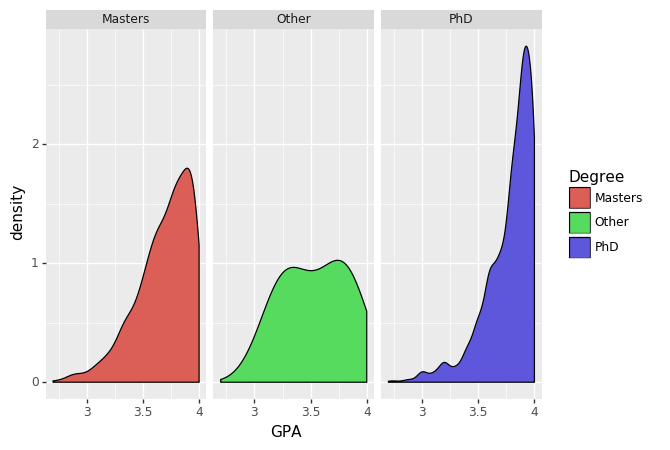

<ggplot: (-9223371859199837252)>

In [4]:
# GPA by degree
gg = p9.ggplot(df[~pd.isna(df.Undergrad_GPA)], p9.aes(x='Undergrad_GPA', fill='degree'))
gg += p9.geom_density()
gg += p9.scale_fill_discrete(name='Degree')
gg += p9.facet_wrap('~degree')
gg += p9.labs(x='GPA')
gg
# As expected, PhD applicants have much higher GPA

## Compare GPA grouped by different student pools

We created four density plots of applicants' GPA by locations of applicants' undergraduate institution and nationality: whether applicants received a degree from U.S. or international institution, and whether the applicant is U.S. citizen or not.

Most applicants have a GPA over 3.5 across all four locations, though the number is particularly high for international applicants with a U.S. degree where most applicants have a GPA around 3.9. However, the general distribution for all four locations is similar and there is no significant difference across locations.

It worths noticing that different institutions have different GPA systems and policies: some insitutions and programs tend to have a more strict grading policy than others.

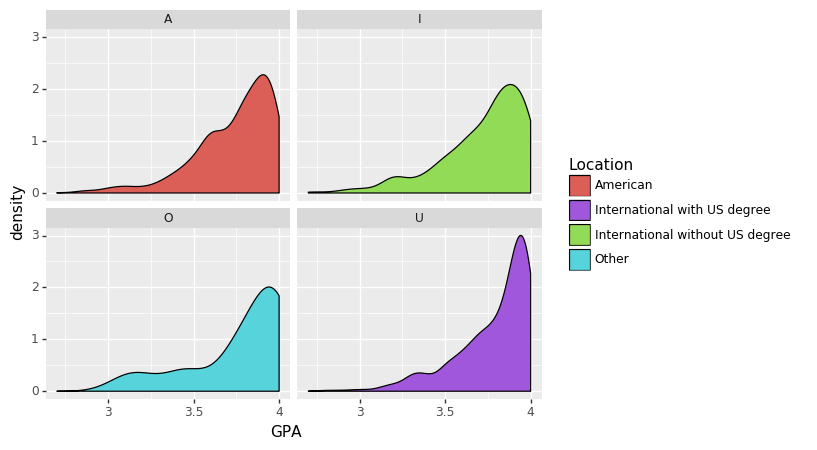

<ggplot: (-9223371859199345244)>

In [5]:
# GPA by location
loc = ['American', 'International with US degree', 'International without US degree', 'Other']

gg = p9.ggplot(df[(~pd.isna(df.Undergrad_GPA))&(~pd.isna(df.ST))], p9.aes(x='Undergrad_GPA', fill='ST'))
gg += p9.geom_density()
gg += p9.scale_fill_discrete(name='Location',breaks=['A', 'U', 'I', 'O'] , labels=loc)
gg += p9.facet_wrap('~ST')
gg += p9.labs(x='GPA')
gg
# International students with US degree tend to have higher GPA

## GRE by different student pools

GRE score is another important indicator of applicant competency and mostly required by Statistics postgraduate programs. GRE score constitutes three parts: quantitative, verbal, and analytical writing. We created four density plots of applicants' GRE by locations of applicants' undergraduate institution and nationality.


### GRE: Analytical Writing

As expected, Americans generally have higher analytical writing scores than international students; international students with a U.S. degree tend to have higher scores than those without a U.S. degree. This conclusion makes sense as analytical writing is conducted in English; applicants with U.S. degree or are native speakers should achieve higher score in this section.

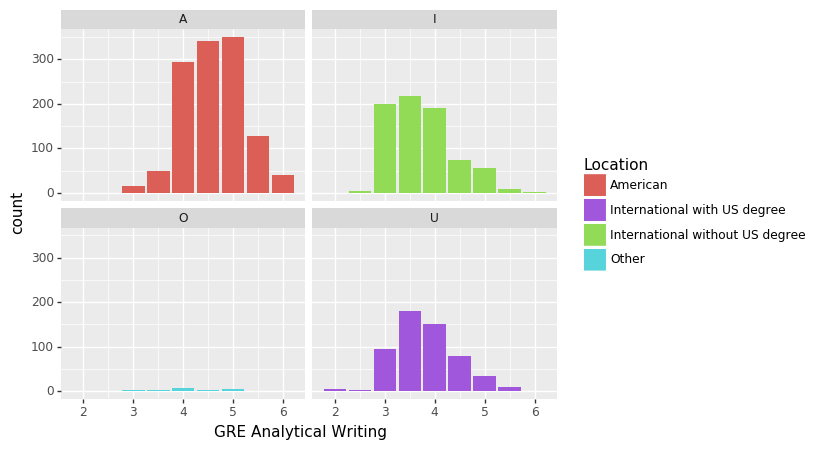

<ggplot: (-9223371859199093104)>

In [6]:
# GRE AW by location

gg = p9.ggplot(df[(~pd.isna(df.GRE_W))&(~pd.isna(df.ST))], p9.aes(x='GRE_W', fill='ST'))
gg += p9.geom_col(stat='count')
gg += p9.scale_fill_discrete(name='Location',breaks=['A', 'U', 'I', 'O'] , labels=loc)
gg += p9.facet_wrap('~ST')
gg += p9.labs(x='GRE Analytical Writing')
gg
# International students without US degree tend to have lower GRE AW

### GRE: Verbal
We can see a similar distribution as in analytical writing, where verbal score is highly related with English language capability. Since some applicants did not report their location on Gradcafe, we have an abnormal distribution for applicants with other location.

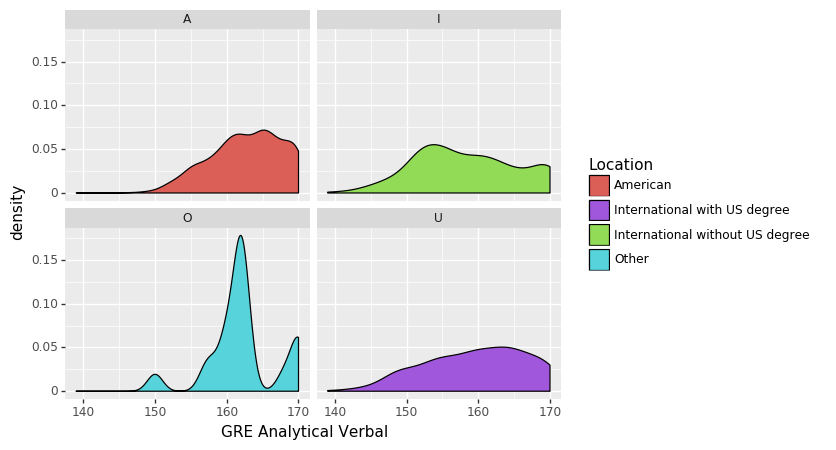

<ggplot: (-9223371859198971576)>

In [7]:
# GRE V by location

gg = p9.ggplot(df[(~pd.isna(df.GRE_V))&(~pd.isna(df.ST))], p9.aes(x='GRE_V', fill='ST'))
gg += p9.geom_density()
gg += p9.scale_fill_discrete(name='Location',breaks=['A', 'U', 'I', 'O'] , labels=loc)
gg += p9.facet_wrap('~ST')
gg += p9.labs(x='GRE Analytical Verbal')
gg
# International students without US degree tend to have lower GRE V

### GRE: Quantitative
For quantitative section, international applicants tend to have a close-to-perfect score, which is much higher than that of American applicants and international applicants with a U.S. degree.

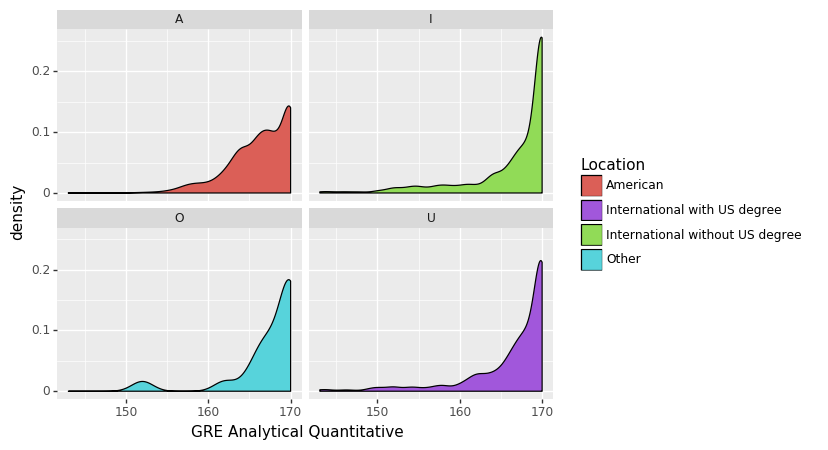

<ggplot: (-9223371859198613280)>

In [8]:
# GRE Q by location

gg = p9.ggplot(df[(~pd.isna(df.GRE_Q))&(~pd.isna(df.ST))], p9.aes(x='GRE_Q', fill='ST'))
gg += p9.geom_density()
gg += p9.scale_fill_discrete(name='Location',breaks=['A', 'U', 'I', 'O'] , labels=loc)
gg += p9.facet_wrap('~ST')
gg += p9.labs(x='GRE Analytical Quantitative')
gg
# International students without US degree tend to have higher GRE Q

## Average timeline of admission decisions
We compare the timelines of different institutions in terms of making decisions on PhD admission. This is presented by yearly aggregated counts of events. For example, we compare **UC Davis** and **Stanford**.

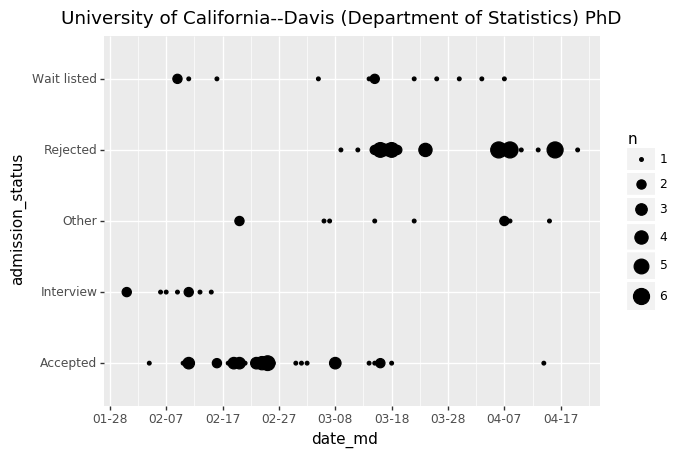

<ggplot: (-9223371859198714688)>

In [9]:
event_counts_date({"institution": "Davis", "degree": "PhD"})

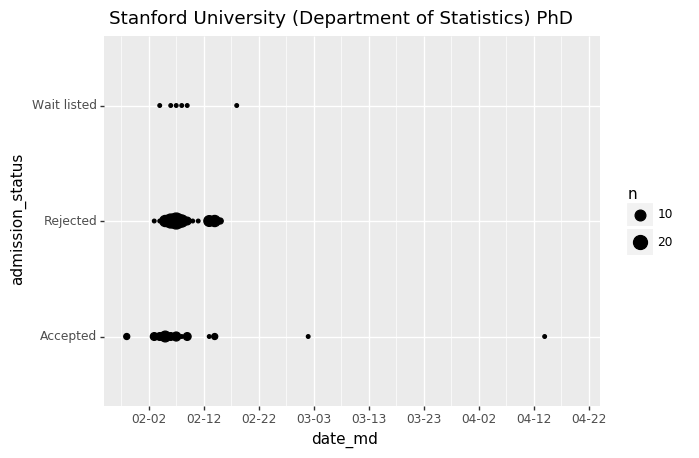

<ggplot: (-9223371859197422480)>

In [10]:
event_counts_date({"institution": "Stanford", "degree": "PhD"})

We see that Stanford is considerably earlier in terms of making decisions on admissions and rejections. Most of their decisions are made before the middle of Feburary, when UC Davis is still beginning to interview applicants and give offers. Another interesting fact is that Stanford seems to never interview applicants.

After comparing more timelines of different schools, we find that schools with higher ranking tend to make decisions earlier. This fact is consistent with our common sense.

## Which school is the hardest to get in?
Although this dataset from Gradcafe can only represent a small part of the applicants, it's nevertheless interesting to compare the acceptance rate among all applicants of different programs, which we believe would partially reflect the difficulty in getting in this program.

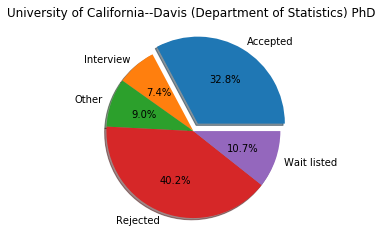

In [11]:
prop_piechart("admission_status", {
                  "institution": "Davis", "degree": "PhD"})

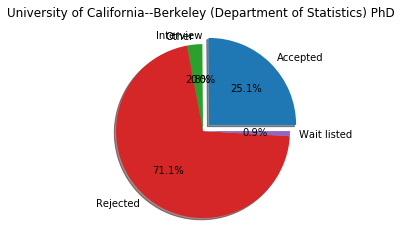

In [12]:
prop_piechart("admission_status", {
                  "institution": "Berkeley", "degree": "PhD"})

Comparing UC Davis and Berkeley, the rejection rate of Berkeley is considerably higher. Berkeley ranks top 2 in Statistics subject according to USnews, and it is very difficult to get in.

We can see which school has the lowest admission rate of Stats PhD, by an naively estimate--the count of admission divided by the sum of the counts of admission and rejection. Following is the ranking of acceptance rate in our data.

In [13]:
def summary_admission_prop(x):
    t = x["admission_status"].value_counts()
    return t["Accepted"] / (t["Accepted"] + t["Rejected"])
(df.loc[df["degree"] == "PhD"]).groupby(
    "institution").apply(summary_admission_prop).sort_values()[df["institution"].value_counts() >= 100]

institution
Duke University (Department of Statistical Science)                                           0.175758
University of Pennsylvania (Department of Statistics)                                         0.191667
Harvard University (Department of Statistics)                                                 0.217687
Yale University (Department of Statistics)                                                    0.246914
University of California--Berkeley (Department of Statistics)                                 0.261084
Cornell University (Department of Statistical Science)                                        0.276596
Stanford University (Department of Statistics)                                                0.277778
University of Washington (Department of Statistics)                                           0.278884
Carnegie Mellon University (Department of Statistics)                                         0.280576
Columbia University (Department of Statistics)               

However, we should keep in mind that this dataset may be a biased sample, or in other words, missing not at random. For example, people may be more likely to report their acceptance than to report rejection on Gradcafe. Therefore, we expect this acceptance rate to be an overestimate--You will not believe OSU accept 77% of all applicants each year!

## Proportion of International Student
As PhDs in Statistics in UC Davis, we found the proportion of international students in our department to be particularly high. Is this also true for other schools?

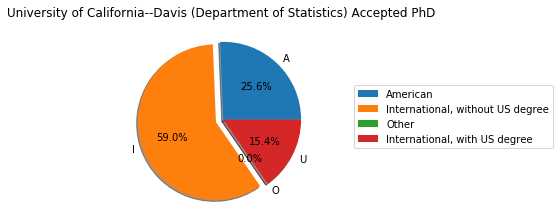

In [14]:
prop_piechart("ST", {"institution": "Davis",
                         "admission_status": "Accepted", "degree": "PhD"})

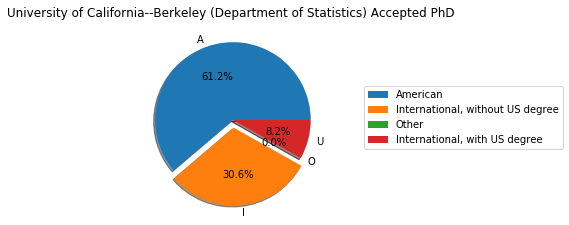

In [15]:
prop_piechart("ST", {"institution": "Berkeley",
                         "admission_status": "Accepted", "degree": "PhD"})

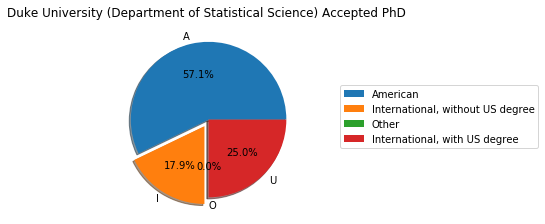

In [16]:
prop_piechart("ST", {"institution": "Duke",
                         "admission_status": "Accepted", "degree": "PhD"})

We found that many other schools, e.g. Duke and UC Berkeley, do not have so many international PhDs as in UC Davis Statistics.

We can have a look at which school prefers international students most in terms of PhD in Statistics.

In [17]:
def summary_ST_prop(x):
    t = x["ST"].value_counts()
    return t["I"]/np.sum([t[i] for i in t.index])
(df.loc[(df["admission_status"] == "Accepted") & (df["degree"] == "PhD")]).groupby(
        "institution").apply(summary_ST_prop).sort_values(ascending=False)[df["institution"].value_counts() >= 100]

institution
Stanford University (Department of Statistics)                                                0.625000
Columbia University (Department of Statistics)                                                0.621622
University of California--Davis (Department of Statistics)                                    0.589744
Harvard University (Department of Statistics)                                                 0.566667
Yale University (Department of Statistics)                                                    0.526316
University of Chicago (Department of Statistics)                                              0.526316
University of Pennsylvania (Department of Statistics)                                         0.500000
University of Minnesota--Twin Cities (School of Statistics)                                   0.500000
University of Michigan--Ann Arbor (Department of Statistics)                                  0.447368
University of Connecticut (Department of Statistics)         

Still, we need to point out that this dataset may be a biased sample of the whole applicants. We believe that the proportion of international students in this dataset is likely to be underestimated, because many international students do not report on Gradcafe (they do not even know this website).

## Admission rate among the United States

In this part, we show some interactive chropleth map, which is about the average admisson rate, average statistic score and numbers of applicants across the entire states. Admittedly, this is not the most useful way to look at gradcafe admission dataset, but still provides an interesting look at the relative numbers and admission conditions among different states.

The admission rate is the number of acceptances divided by the number of applicants. It is important to note that students can apply to many schools and can be accepted by many schools at the same time. In this figure, we mark the top three states with the highest admission rate as well as two states with the lowest one. It turns out that some states like Florida, Georgia and Alabama, which are not very popular among the applicants, have the highest admission rate. States in the east coast are harder to be admitted. North Carolina has the lowest admission rate with the average of 25%. There are many selective and famous public and private colleges in North Carolina such as Duke University, University of North Carolina at Chapel Hill. Leading the list is Duke University which sent acceptance letters to only 17% students. These schools have less rigorous tests and high school GPA requirements may receive a large numbers of qualified applicants and the school may not have space to admit them all.

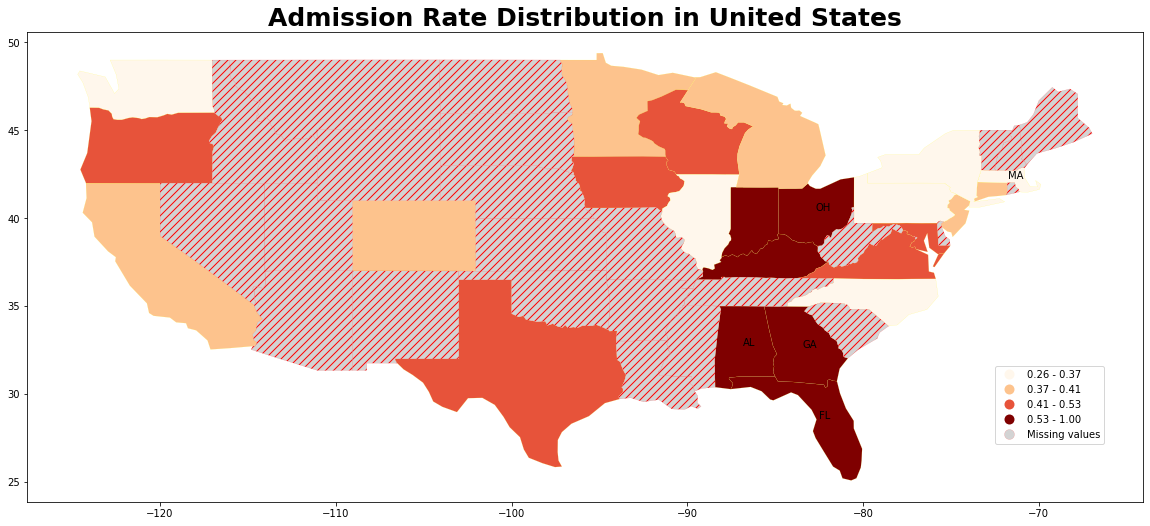

In [18]:
geo_figure2(feature = "admission_rate")

##  Average Statistics Score in each state.

In this part, we show the average statistic score in each state. The average score is based on the score information from USnews statistics rank. From the interactive chropleth map, we mark top twelve states with the highest average statistics score. 

Below, we calculate the top ten states with the highest statistics average score. Leading the list in washington state. This result is partially from our ranking data where there is only one university-- University of Washington, which has first tier statistics program, in washington. However, in general, we can see some states in west coast, east coast and some where in the middle near the five lakes areas has the best statistics programs.

In [19]:
df_stat = pd.read_csv('../data/USnew_stat_rank.csv')
df_stat["postal"] = df_stat["district"].str.split(',', expand = True).iloc[:,1].str.strip()
s = df_stat[["postal", "score"]].groupby("postal").mean()
s.sort_values(by = ["score"], ascending = False).head(10)

,score
postal,
WA,4.450000
MI,3.766667
MN,3.700000
MD,3.566667
NC,3.566667
WI,3.500000
PA,3.428571
CA,3.427273
MA,3.380000


In [20]:
geo_figure1(feature = "stat_score")

Loading BokehJS ...

## States preference during application

According to the [National Association for College Admission Counseling](https://www.nacacnet.org), in 1990, 9% of college freshmen applied to seven or more schools. By 2016, this percentage had increased to 35%. From the table below we can see the top 20 institution that receive the most applications for statistics program.  In the table summary below, we find that students prefer to apply for some tier 1 statistics programs. As for the difference among the states, we found that California is the most popular places for applicants. In the top 20 institution, four of them are from California

In [21]:
s = df[["institution", "program"]].groupby("institution").count().rename(columns = {"program": "count"})
s = s.merge(df_stat[["name","rank","postal"]], how = 'left', left_index = True, right_on = "name").rename(columns = {"name": "institution"}).set_index("institution")
s.sort_values(by = ["count"], ascending = False).head(20)

,count,rank,postal
institution,,,
University of Chicago (Department of Statistics),490,6.0,IL
University of Michigan--Ann Arbor (Department of Statistics),417,12.0,MI
University of Washington (Department of Statistics),389,8.0,WA
Columbia University (Department of Statistics),379,16.0,NY
Carnegie Mellon University (Department of Statistics),377,8.0,PA
North Carolina State University--Raleigh (Department of Statistics),358,16.0,NC
University of California--Berkeley (Department of Statistics),339,2.0,CA
Stanford University (Department of Statistics),337,1.0,CA
Duke University (Department of Statistical Science),281,12.0,NC


In [22]:
geo_figure3(feature = "num_applicants")

Loading BokehJS ...

Like the state itself, California's buffet of educational offerings is expansive, varied and colorful. As the most popular stats in the U.S. as well as the most economically fertile, California is home to a formidable population of college and university students. Another reason why California is popular is California's public higher education system, which has less tuition fees compared with private universities. 

In [23]:
df_stat[df_stat["postal"] == "MA"]

,Unnamed: 0,score,name,rank,district,postal
2,2,4.6,Harvard University (Department of Biostatistics),3.0,"Boston, MA",MA
5,5,4.4,Harvard University (Department of Statistics),6.0,"Cambridge, MA",MA
49,49,3.0,Boston University (School of Public Health),50.0,"Boston, MA",MA
77,77,2.5,University of Massachusetts--Amherst (Departme...,74.0,"Amherst, MA",MA
82,82,2.4,University of Massachusetts--Amherst (Division...,79.0,"Amherst, MA",MA


# Decision Tree Classifier for *admission_status*

Based on EDA, we want to further look into the mechanism of graduate admission and hope to guide the application of prospective students. Given the complexity and diversity of the data, we constructed a decision tree classifier to find the influential factors in graduate application.

**Response**

*admission_status*: Accepted, Rejected, Other

**Predictors**

*degree*: Masters, PhD

*admission_via*: E-mail, Other, Website

*ST* (source of students): I, A, U

*Undergrad_GPA*, *GRE_V*, *GRE_Q*, *GRE_W*, *GRE_sub*, *USnew_stat_score*, *USnew_overall_score*

**Methods**

1. encode categorical features (*degree*, *admission_via*, *ST*) as a one-hot numeric array. (decision_tree_process function)
2. split dataset into random train and test subsets.
3. train decision tree classifier and post prune decision trees with cost complexity pruning.

In [24]:
X, y = decision_tree_process(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

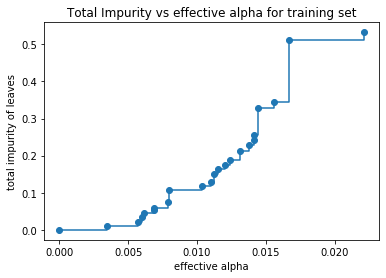

In [25]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [26]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

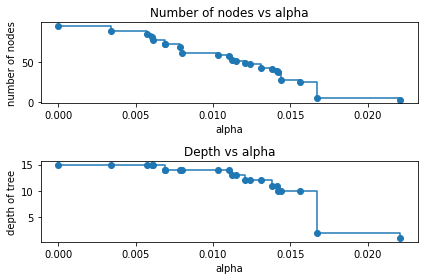

In [27]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

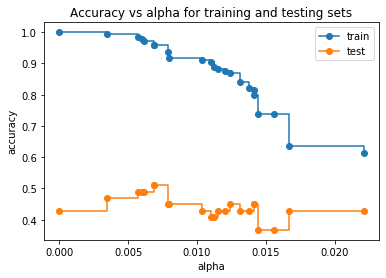

In [28]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

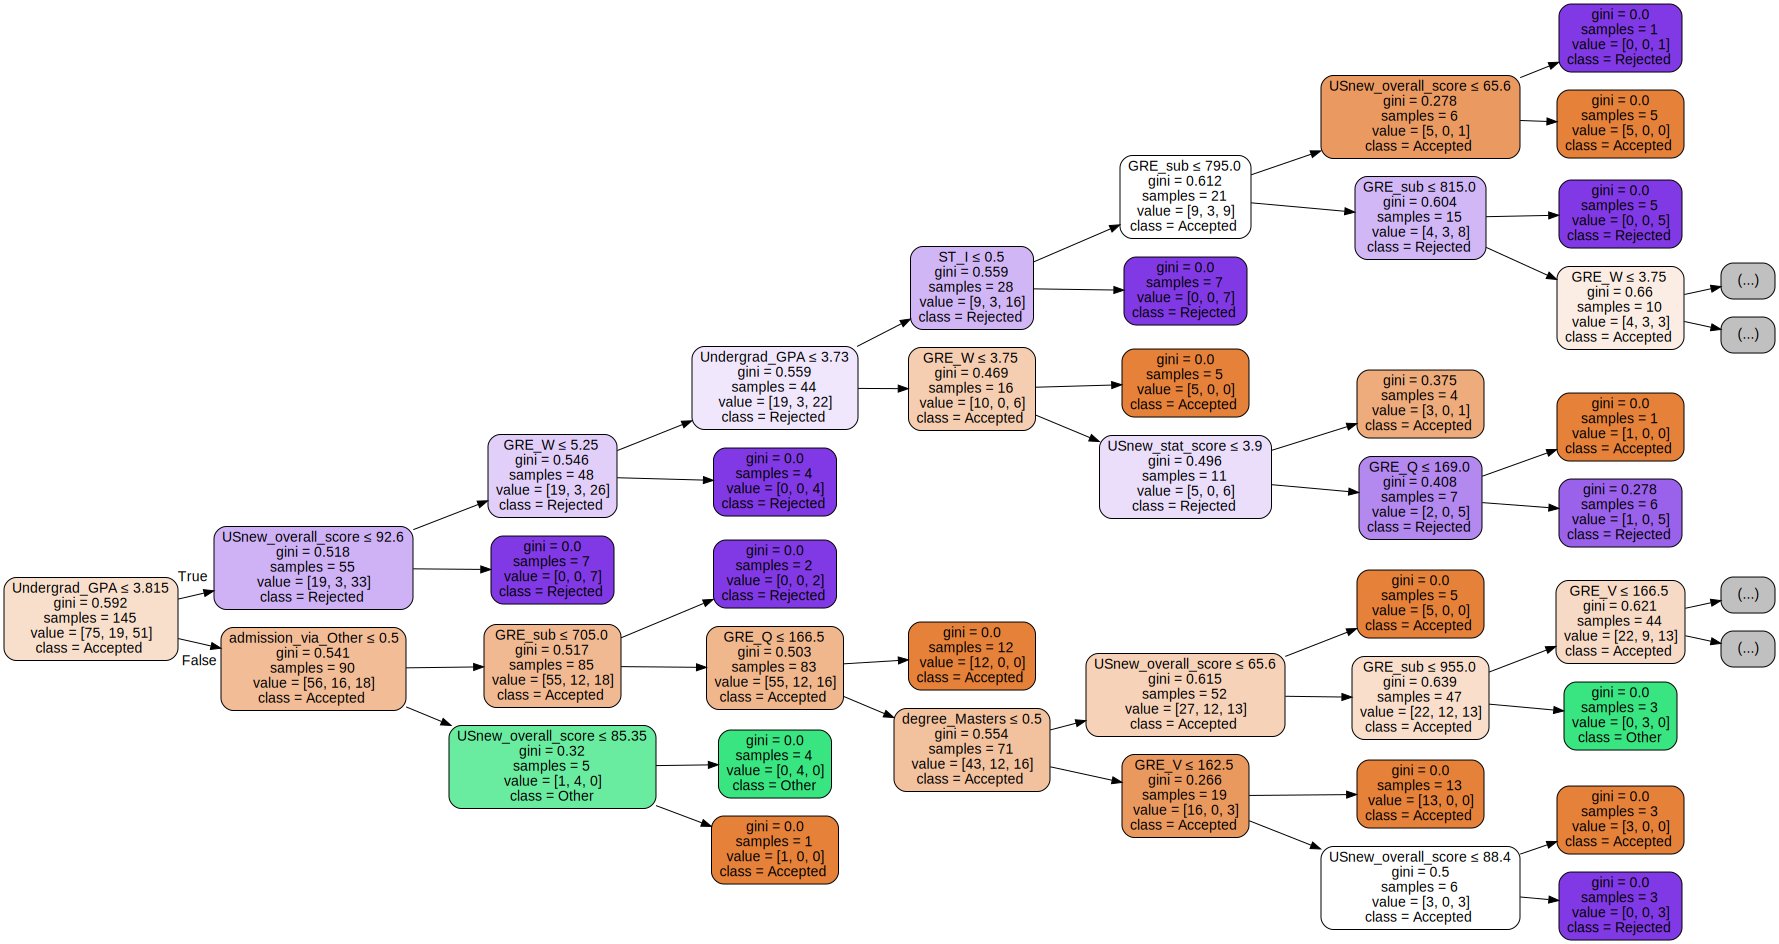

In [29]:
clfopt = clfs[np.argmax(test_scores)]# best tree in terms of prediction accuracy
dot_data = tree.export_graphviz(clfopt, out_file=None,
                     feature_names=X.columns,
                     class_names=sorted(y.unique().tolist()),
                     filled=True, rounded=True,
                     rotate=True, max_depth=7, 
                     special_characters=True)
graph = graphviz.Source(dot_data)
# graph.render("status_tree")
graph

### Interpretation of decision tree classifier

Because of the large amount of missing data, the decision tree classifier does not perform very well in terms of prediction accuracy (0.51). Data imputation does not make sense in this case since almost all missing data happens in numerical variables such as GPA and GRE and missing is not random. We can neither impute randomly nor with other variables.

However, the classifier does provide some important interpretations towards graduate application (statistics). First, undergraduate GPA plays an essential role in graduate application (statistics). One needs to focus on his/her courses during undergraduate if he/she wants to apply for a competetive statistics graduate program. Second, GRE sub is important if undergraduate GPA is not competetive. Meanwhile, due to data limitation, we can not include other important factors, such as recommendation and undergraduate school, into our classifier, which may affect the performance of it.

# Text Analysis based on *Notes*
Similarly, we can build a decision tree based on the notes left by the applicants. There is usually lots of information given in the notes, sometimes even more relevant and informative than quantitive variables like GPA.

We therefore raise an interesting question here: can we use notes only to predict one's admission status? This should make sense--sometimes we can tell one's result by simply looking at the notes he left. To answer this question, we once again construct a decision tree. We use the tfidfVectorized notes as the predictors.

20 Most Important Words:  ['funding' 'please' 'below' 'anyone' 'rejection' 'ta' 'sad' 'offer'
 'tuition' 'the' 'interview' 'to' 'excited' 'expected' 'not' 'from'
 'fellowship' 'rejected' 'check' 'wait']
10-fold Cross Validation Accuracy:  0.6677030221336614


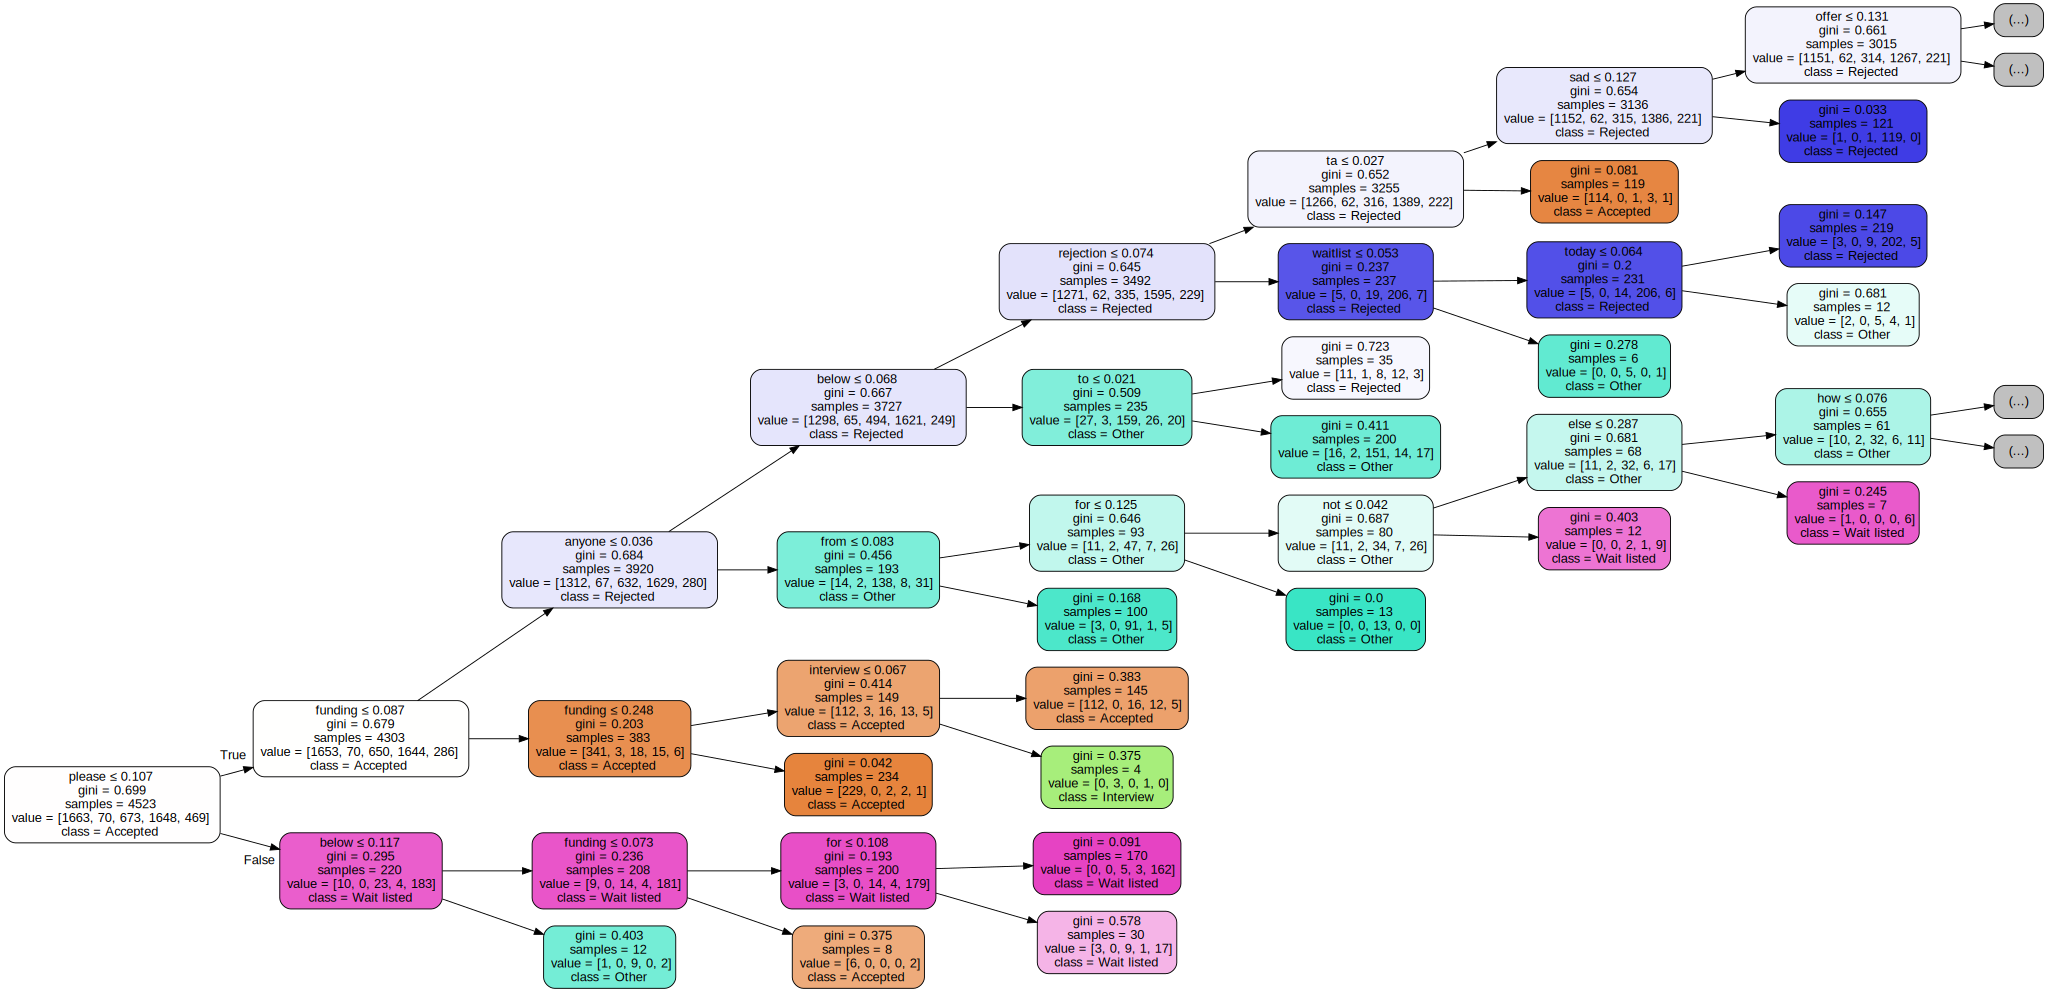

In [30]:
notes_decision_tree_classifier()

Although, as expected, the notes itself does not have much predicting power (CV accuracy: 0.66), the nodes on top of the tree are rather interesting. To our surprise, the most important nodes is "please". This actually makes sense. When someone says "please", he/she is very likely to be "Waitlisted"--he/she is urging those who are holding offers but not joining to decline as soon as possible.

In [31]:
for i in df["notes"].dropna()[lambda x: x.str.contains("please", case=False)].head(8):
    print(i)

I have been informed that I am the first person on the wait list. If you have been accepted and are not planning to attend, please inform the department as soon as possible. Much appreciated!
Email asked if I wanted to be considered for MA if not admitted to PhD. This is my top choice if anyone got admitted and doesn't want to attend please let the know asap.
TPB: Thank you very much for the information.
I guess I might be on their waiting list. Also for those who got better offers, could you please decline this school as early as possible.
I really want this offer for some reasons.
Hmm it is already April. Could you please turn down your offer if you have better choice. Thank you very much
I am still on waiting list for financial assistance. If you decided not to go JHU, please let them know as soon as possible.
If you decide not to go, please let the school know. Thank you!!!!!
Please withdraw if you got a better offer! This is my last chance :(
For the students who have already rece

The appearance of some other words on the tree also makes sense. For example, if one mentions "funding" or "TA" he is likely to be accepted, while the word "sad" always means one has been rejected.

## WordCloud: What do applicants talk about most?
We generate and compare the WordClouds generated by the notes of PhD and Master applicants, respectively.

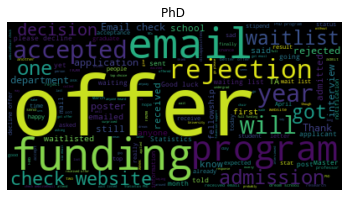

In [32]:
wordcloud_df({"degree": "PhD"})

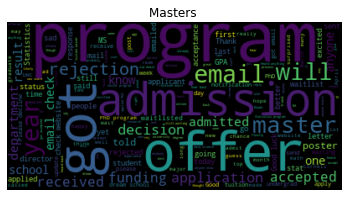

In [33]:
wordcloud_df({"degree": "Masters"})

The topics appearing in PhD and master applicants are very much alike. Interestingly, PhD applicants seems to care more about funding.